In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [66]:
# Standard Libraries
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Machine Learning Libraries
from sklearn.decomposition import PCA

# Deep Learning Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow as tf

# Visualization Libraries
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Gensim Library
from gensim.models import KeyedVectors

In [5]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', names=['company', 'type', 'comment'])


In [6]:
df.sample(5)

,company,type,comment
11203,TomClancysRainbowSix,Positive,Nice game @ Rainbow6Game pic.fm / 6dNHUqNH8P
921,AssassinsCreed,Neutral,Get ready for the weekend with our Special. Of...
10452,RedDeadRedemption(RDR),Positive,Hi everybody it ’ s be just a question would y...
10513,RedDeadRedemption(RDR),Neutral,Red of Rio 2 - Brazil - jogando no Beach Boy.....
566,ApexLegends,Negative,@ PlayApex Xbox Ranking sucks cause it literal...


In [7]:
df = df.drop_duplicates()

In [8]:
df.describe(include='all')

,company,type,comment
count,71061,71061,70958
unique,32,4,69491
top,CallOfDuty,Negative,"At the same time, despite the fact that there ..."
freq,2307,21596,77


In [9]:
df.nunique()

company       32
type           4
comment    69491
dtype: int64

In [10]:
df.isnull().sum()

company      0
type         0
comment    103
dtype: int64

# Analysis for NaN comments

In [11]:
df_temp = df[df.isnull().any(axis=1)]

<Axes: xlabel='type'>

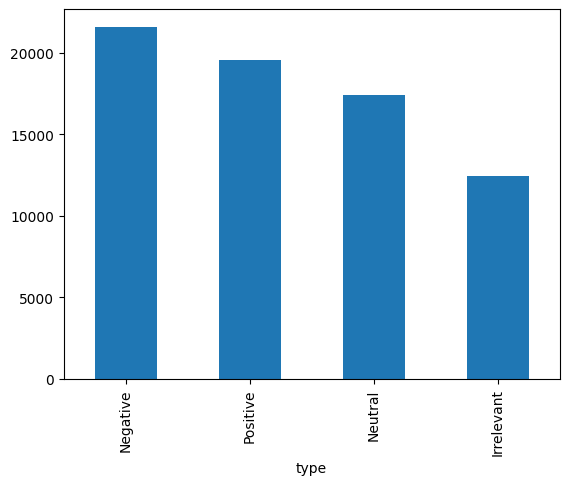

In [12]:
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='company'>

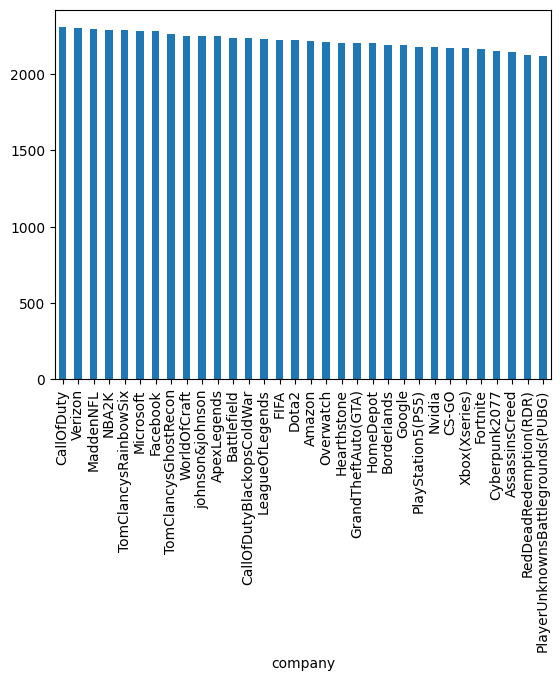

In [13]:
df['company'].value_counts().plot(kind='bar')

<Axes: xlabel='company'>

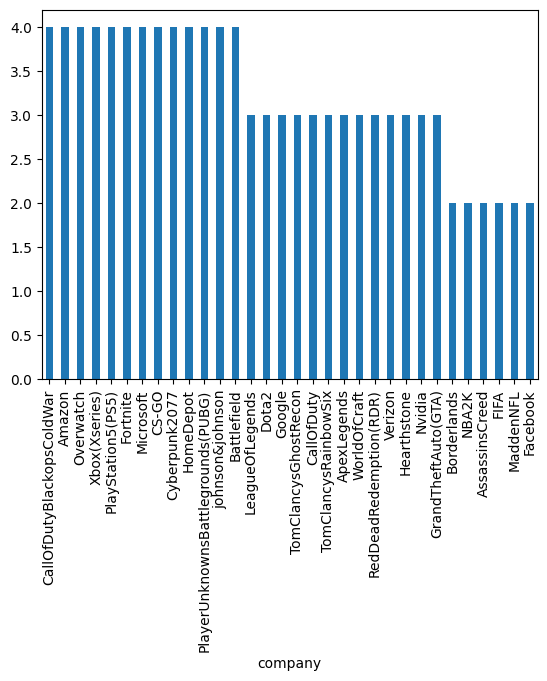

In [14]:
df_temp['company'].value_counts().plot(kind='bar')

<Axes: xlabel='type'>

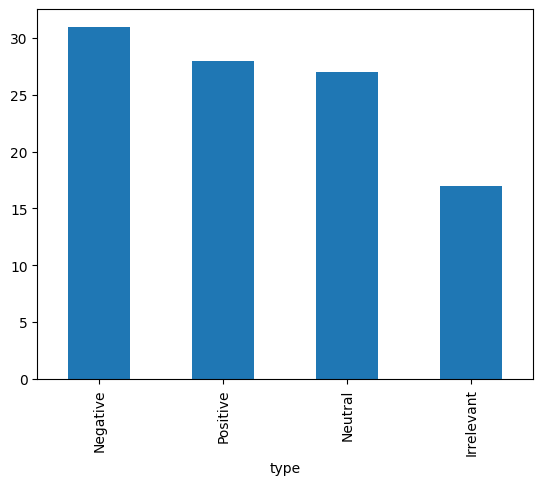

In [15]:
df_temp['type'].value_counts().plot(kind='bar')

# Dropping Extra data

In [16]:
df = df.dropna()

In [17]:
df.shape

(70958, 3)

In [18]:
df = df.drop(columns=['company'])
df.sample(4)

,type,comment
6759,Irrelevant,Can’t stop thinking about how fuckn lit that T...
5318,Negative,Anyone else seeing weird graphical changes in ...
3627,Neutral,nights I want to print the decor from the GOG....
297,Neutral,The Best Amazon Review For .. protect your dev...


# Pre-Processing

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lower case
    text = str(text).lower().strip()

    # Remove emoji
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove html
    pattern = re.compile('<.*?>')
    text = pattern.sub(r'', text)

    # Remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)

    # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('[math]', '')

    # Contractions
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    text_decontracted = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        text_decontracted.append(word)
    text = ' '.join(text_decontracted)

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = re.sub(r'\d+', '', text)

    return text

df['comment'] = df['comment'].apply(preprocess)
df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,type,comment
2401,Positive,im getting borderland murder
2401,Positive,coming border kill
2401,Positive,im getting borderland kill
2401,Positive,im coming borderland murder
2401,Positive,im getting borderland murder


In [20]:
type_mapping = {genre: idx for idx, genre in enumerate(df['type'].unique())}
df['type'] = df['type'].map(type_mapping)

In [21]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,type,comment
0,2,rockstargames working red dead redemption wha...
1,1,buff de ly qus
2,2,pta banning pubg apparently yet another confes...
3,1,would
4,3,battlefield v live tonight fun know play remem...


In [22]:
word2vec_path = '/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Convert descriptions to vectors
def description_to_avg_vector(description):
    words = description.split()
    word_vectors = [word2vec[word] for word in words if word in word2vec]
    if len(word_vectors) == 0:
        return np.zeros(word2vec.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Apply the function to the dataframe
df['avg_vector'] = df['comment'].apply(description_to_avg_vector)
df.head()

,type,comment,avg_vector
0,2,rockstargames working red dead redemption wha...,"[0.087402344, 0.10395304, 0.14846802, 0.065714..."
1,1,buff de ly qus,"[0.033203125, 0.21126302, 0.08605957, 0.068155..."
2,2,pta banning pubg apparently yet another confes...,"[0.08513611, -0.008850098, 0.05807739, 0.09380..."
3,1,would,"[0.08935547, 0.12988281, 0.21289062, 0.1777343..."
4,3,battlefield v live tonight fun know play remem...,"[0.06255165, -0.020155687, 0.0999662, 0.101355..."


# PCA

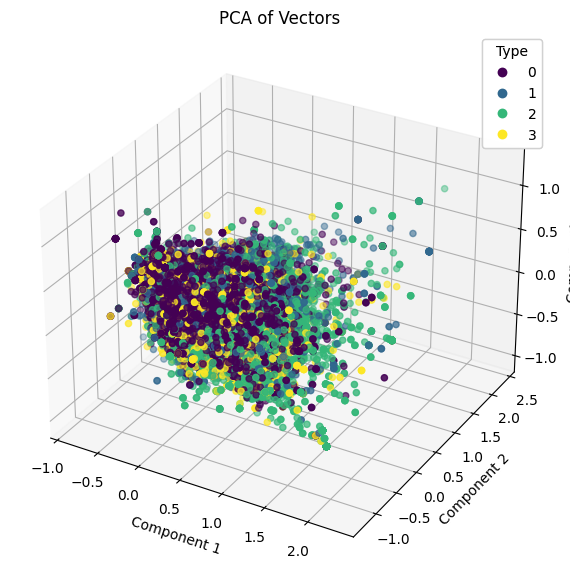

In [23]:
vectors = np.stack(df['avg_vector'].values)
pca = PCA(n_components=3)
reduced_vectors_pca = pca.fit_transform(vectors)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_vectors_pca[:, 0], reduced_vectors_pca[:, 1], reduced_vectors_pca[:, 2], 
                     c=df['type'].astype('category').cat.codes, cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(), title="Type")
ax.add_artist(legend1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('PCA of Vectors')

plt.show()

# Model_1 : Embedding + Bidirectional LSTM

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment'])
len(tokenizer.word_index)

35726

In [25]:
df['Token_comment'] = tokenizer.texts_to_sequences(df['comment'])
df.head(3)

,type,comment,avg_vector,Token_comment
0,2,rockstargames working red dead redemption wha...,"[0.087402344, 0.10395304, 0.14846802, 0.065714...","[842, 225, 47, 38, 88, 25180, 45]"
1,1,buff de ly qus,"[0.033203125, 0.21126302, 0.08605957, 0.068155...","[2652, 1189, 951, 19877]"
2,2,pta banning pubg apparently yet another confes...,"[0.08513611, -0.008850098, 0.05807739, 0.09380...","[4355, 1539, 59, 964, 248, 118, 4700, 6383, 63..."


In [26]:
max_len = max(len(Token_DESCRIPTION) for Token_DESCRIPTION in df['Token_comment'])
max_len

163

In [27]:
df['Token_comment'] = pad_sequences(df['Token_comment'], maxlen=max_len, padding='pre').tolist()
df.head(3)

,type,comment,avg_vector,Token_comment
0,2,rockstargames working red dead redemption wha...,"[0.087402344, 0.10395304, 0.14846802, 0.065714...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,buff de ly qus,"[0.033203125, 0.21126302, 0.08605957, 0.068155...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,pta banning pubg apparently yet another confes...,"[0.08513611, -0.008850098, 0.05807739, 0.09380...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [49]:
X = np.array(df['Token_comment'].tolist())
y = np.array(df['type'].tolist())

In [50]:
X.shape, y.shape

((70958, 163), (70958,))

In [30]:
vocab_size = len(tokenizer.word_index) + 1
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model1.add(Bidirectional(LSTM(128, return_sequences=True)))
model1.add(Bidirectional(LSTM(64)))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())  

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2)) 
model1.add(BatchNormalization()) 

model1.add(Dense(4, activation='softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
stored_parameters1 = []

def your_callback_function(model):
    parameters = model.get_weights()  # Get model parameters (weights and biases)
    stored_parameters1.append(parameters)

history1 = model1.fit(
    X, y,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: your_callback_function(model1)
        )
    ]
)

Epoch 1/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.4474 - loss: 1.3098 - val_accuracy: 0.7527 - val_loss: 0.6676
Epoch 2/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.8253 - loss: 0.5163 - val_accuracy: 0.8193 - val_loss: 0.4947
Epoch 3/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.8952 - loss: 0.3132 - val_accuracy: 0.8451 - val_loss: 0.4500
Epoch 4/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.9188 - loss: 0.2321 - val_accuracy: 0.8408 - val_loss: 0.5095
Epoch 5/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.9304 - loss: 0.1995 - val_accuracy: 0.8556 - val_loss: 0.4903
Epoch 6/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.9362 - loss: 0.1752 - val_accuracy: 0.8652 - val_loss: 0.4557
Epoch 7/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.9451 - loss: 0.1510 - val_accuracy: 0.8630 - val_loss: 0.4900
Epoch 8/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.9498 -

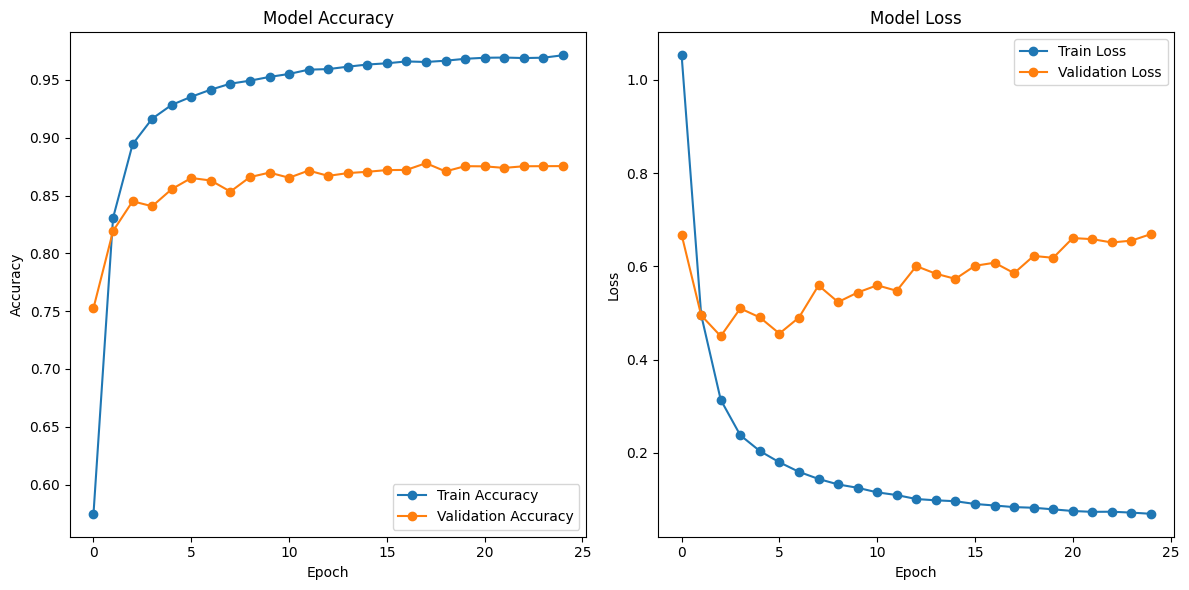

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], marker='o', label='Train Loss')
plt.plot(history1.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [36]:
model1.set_weights(stored_parameters1[2])

# Model_2 : Pre-trained Word2Vec + Bidirectional LSTM

In [37]:
word2vec_path = '/kaggle/input/word2vec-model/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vocab_size = len(tokenizer.word_index) + 1
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, word2vec.vector_size))
for word, index in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        embedding_matrix[index] = np.random.randn(word2vec.vector_size)

In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=word2vec.vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
model2.add(Bidirectional(LSTM(150, return_sequences=True)))
model2.add(Bidirectional(LSTM(75)))

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())  

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2)) 
model2.add(BatchNormalization()) 

model2.add(Dense(4, activation='softmax'))

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │    10,718,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,718,100 (40.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,718,100 (40.89 MB)

In [54]:
stored_parameters2 = []

# Define your callback function to store model parameters
def your_callback_function(model):
    parameters = model.get_weights()  # Get model parameters (weights and biases)
    stored_parameters2.append(parameters)

# Assuming 'model' is defined and compiled before this step
history = model2.fit(
    X, y,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: your_callback_function(model2)
        )
    ]
)

Epoch 1/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.4282 - loss: 1.3183 - val_accuracy: 0.5719 - val_loss: 1.0443
Epoch 2/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 86s 49ms/step - accuracy: 0.6003 - loss: 0.9942 - val_accuracy: 0.6554 - val_loss: 0.8692
Epoch 3/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 86s 49ms/step - accuracy: 0.6957 - loss: 0.7866 - val_accuracy: 0.6912 - val_loss: 0.7881
Epoch 4/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 86s 49ms/step - accuracy: 0.7714 - loss: 0.6073 - val_accuracy: 0.7399 - val_loss: 0.7188
Epoch 5/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.8178 - loss: 0.4925 - val_accuracy: 0.7657 - val_loss: 0.6469
Epoch 6/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.8514 - loss: 0.4004 - val_accuracy: 0.7671 - val_loss: 0.6620
Epoch 7/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.8806 - loss: 0.3339 - val_accuracy: 0.8038 - val_loss: 0.5973
Epoch 8/25
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.9014 -

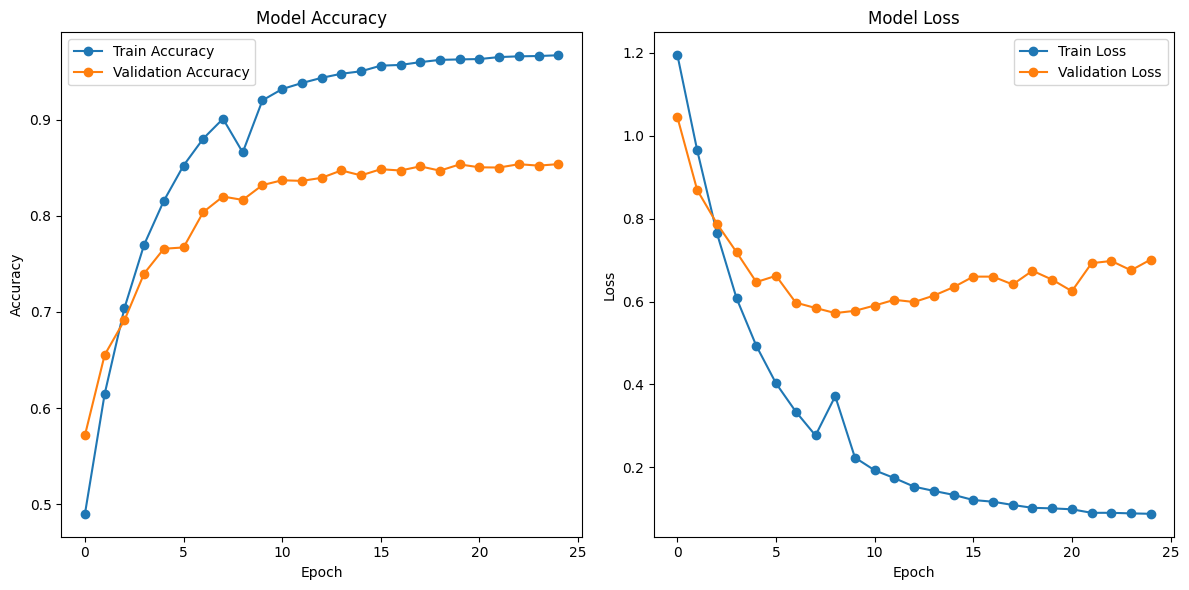

In [56]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
model2.set_weights(stored_parameters2[9])

In [46]:
df_test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names=['company', 'type', 'comment'])
df_test = df_test.drop_duplicates()
df_test = df_test.dropna()
df_test = df_test.drop(columns=['company'])
df_test['comment'] = df_test['comment'].apply(preprocess)
df_test['type'] = df_test['type'].map(type_mapping)
df_test['Token_comment'] = tokenizer.texts_to_sequences(df_test['comment'])
df_test['Token_comment'] = pad_sequences(df_test['Token_comment'], maxlen=max_len, padding='pre').tolist()
X = np.array(df_test['Token_comment'].tolist())
y = np.array(df_test['type'].tolist())
model1.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9144 - loss: 0.2835


[0.2761573791503906, 0.9139999747276306]

# Model Testing

In [64]:
df_test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names=['company', 'type', 'comment'])
df_test = df_test.drop_duplicates()
df_test = df_test.dropna()
df_test = df_test.drop(columns=['company'])
df_test['comment'] = df_test['comment'].apply(preprocess)
df_test['type'] = df_test['type'].map(type_mapping)
df_test['Token_comment'] = tokenizer.texts_to_sequences(df_test['comment'])
df_test['Token_comment'] = pad_sequences(df_test['Token_comment'], maxlen=max_len, padding='pre').tolist()
X = np.array(df_test['Token_comment'].tolist())
y = np.array(df_test['type'].tolist())


loss1, accuracy1 = model1.evaluate(X, y, verbose=0)
loss2, accuracy2 = model2.evaluate(X, y, verbose=0)

results = {
    "Model": ["Model 1", "Model 2"],
    "Loss": [loss1, loss2],
    "Accuracy": [accuracy1, accuracy2]
}

df_results = pd.DataFrame(results)
df_results

,Model,Loss,Accuracy
0,Model 1,0.276157,0.914
1,Model 2,0.315279,0.918
